In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

如果你在用linux就直接执行下面这段代码

不是的话请手动下载数据集并解压到./datasets

In [2]:
# !wget "https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/download?datasetVersionNumber=7"
# !mkdir datasets
# !mv archive.zip datasets
# !unzip datasets/archive

### 1. Data Cleaning

- Load the dataset using pandas.
- Handle missing values and clean the data appropriately.
- Convert data types if necessary (e.g., converting strings to numerical values).

####  1.1 Load the dataset using pandas.

In [37]:
pwd = os.getcwd()
data_dir = os.path.join(pwd,'datasets')
files = os.listdir(data_dir)
dfs = []

for file in files:
    if file.endswith('.csv'):
        if file.endswith('_small.csv'): continue
        df = pd.read_csv(os.path.join(data_dir,file),low_memory=False)
        dfs.append(df)

#### 1.2 Handle missing values and clean the data appropriately.

In [38]:
for df in dfs:
    df.fillna(-1, inplace=True)

#### 1.3 Convert data types if necessary 

In [39]:
meta_df = dfs[-2]
rating_df = dfs[-1]

In [41]:
# 可以发现df4中全是object，我们需要将其中一些列转化为可数值。
# 一些true or false 需要转化为bool

for i,df in enumerate(dfs):
    types = ''
    for col in df.columns:
        types += str(df[col].dtype) + ' '
    print(f"dataframe {i+1}:",types)
    
tf_columns = ['adult','video']
columns = ['id','budget','popularity','revenue','runtime','vote_average','vote_count']
for col in columns:
    meta_df[col] = pd.to_numeric(meta_df[col], errors='coerce')
# for col in tf_columns:
#     meta_df[col] = meta_df[col] == "True"
meta_df['imdb_id'] = meta_df['imdb_id'].str.replace('tt', '')
meta_df['release_date'] = pd.to_datetime(meta_df['release_date'], errors='coerce')

print("Transformed:")
for i,df in enumerate(dfs):
    types = ''
    for col in df.columns:
        types += str(df[col].dtype) + ' '
    print(f"dataframe {i+1}:",types)

dataframe 1: object object int64 
dataframe 2: int64 object 
dataframe 3: int64 int64 float64 
dataframe 4: object object float64 object object float64 object object object object float64 object object object datetime64[ns] float64 float64 object object object object object float64 float64 
dataframe 5: int64 int64 float64 int64 
Transformed:
dataframe 1: object object int64 
dataframe 2: int64 object 
dataframe 3: int64 int64 float64 
dataframe 4: object object float64 object object float64 object object object object float64 object object object datetime64[ns] float64 float64 object object object object object float64 float64 
dataframe 5: int64 int64 float64 int64 


### 2. Exploratory Data Analysis
- Generate summary statistics for the numerical columns.
- Explore the distribution of movie ratings and revenues.
- Identify the top 10 highest-grossing movies.

#### 问题

我觉得id和一些杂七杂八的项不应该当做统计数据。（但是其实也算numerical）

我这里列了一下每个文件可能需要统计的值：

|表格名|要统计的列|
|:--|:--|
|credits.csv|None|
|keywords.csv|可能词频是需要的？|
|links.csv|链接表，没有|
|movies_metadata.csv|adults,revenue,popularity,runtime,vote_average,vote_count,budget|
|ratings.csv|rating|

#### 2.1 Generate summary statistics for the numerical columns.
```python
statics_df = pd.merge(meta_df,dfs[-1], left_on='id', right_on='movieId',how='left')
```
原本的并联方式有数据丢失，应该改成左连接，但是改完还是有数据丢失，所有干脆直接改成统计完之后再合并

In [7]:
colomns = ['adult','revenue','runtime','popularity','vote_average','vote_count','budget']

df_d0 = pd.DataFrame(meta_df[colomns].describe())
df_d1 = dfs[-1]['rating'].describe()
df_d0['rating'] = df_d1
df_d0

,revenue,runtime,popularity,vote_average,vote_count,budget,rating
count,4.546600e+04,45466.000000,45465.000000,45466.000000,45466.000000,4.546300e+04,2.602429e+07
mean,1.120787e+07,93.583711,2.921157,5.617466,109.882836,4.224579e+06,3.528090e+00
std,6.432813e+07,38.956167,6.005162,1.925171,491.279576,1.742413e+07,1.065443e+00
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,5.000000e-01
25%,0.000000e+00,85.000000,0.385825,5.000000,3.000000,0.000000e+00,3.000000e+00
50%,0.000000e+00,95.000000,1.127443,6.000000,10.000000,0.000000e+00,3.500000e+00
75%,0.000000e+00,107.000000,3.678394,6.800000,34.000000,0.000000e+00,4.000000e+00
max,2.787965e+09,1256.000000,547.488298,10.000000,14075.000000,3.800000e+08,5.000000e+00


#### 2.2 Explore the distribution of movie ratings and revenues.

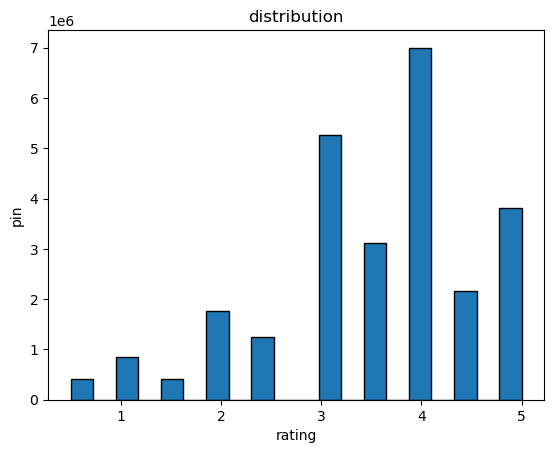

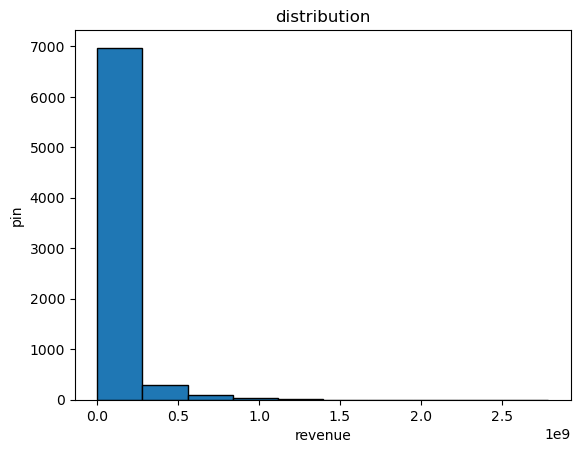

In [57]:
plt.figure()
plt.hist(dfs[-1]['rating'].dropna(), bins=20, edgecolor='black')
plt.title('distribution')
plt.xlabel('rating')
plt.ylabel('pin')
plt.show()

filtered_data = meta_df[meta_df['revenue'] != 0]['revenue']

plt.figure()
plt.hist(filtered_data.dropna(), bins=10, edgecolor='black')
plt.title('distribution')
plt.xlabel('revenue')
plt.ylabel('pin')
plt.show()

#### 2.3 Identify the top 10 highest-grossing movies.

原本那个统计的结果有点问题，可能是在并联或者去0 的时候出问题了，不如直接拿原始数据来排序

In [9]:
top10_highest_grossing = meta_df.nlargest(10, 'revenue')[['title', 'revenue']]
top10_highest_grossing

,title,revenue
14551,Avatar,2.787965e+09
26555,Star Wars: The Force Awakens,2.068224e+09
1639,Titanic,1.845034e+09
17818,The Avengers,1.519558e+09
25084,Jurassic World,1.513529e+09
28830,Furious 7,1.506249e+09
26558,Avengers: Age of Ultron,1.405404e+09
17437,Harry Potter and the Deathly Hallows: Part 2,1.342000e+09
22110,Frozen,1.274219e+09
42222,Beauty and the Beast,1.262886e+09


### 3. Genre Analysis
- Create a new column that lists the genre of each movie.
- Determine the most common movie genre.
- Analyze the average rating by genre.

#### 3.1 Create a new column that lists the genre of each movie.

我的理解是每个genres都是一行，每个电影对应n个genres

用for十分的慢，不知道让不让用numpy，numpy快很多

In [10]:
import ast

genres_df = pd.DataFrame()
new_df = meta_df[['title','id','genres']]
for i in range(len(new_df)):
    item = new_df.iloc[i]
    json = ast.literal_eval(item['genres'])
    genres = pd.json_normalize(json)
    genres[['movieId','title']] = item[['id','title']]
    genres_df = pd.concat([genres_df, genres], ignore_index=True)

In [24]:
# genres_df[['movieId',]] = genres_df[['movieId','id']].astype('int64')
genres_df['id'] = genres_df['id'].astype('int64')
genres_df.fillna(-1, inplace=True)
genres_df['movieId'] = genres_df['movieId'].astype('int64')
genres_df.columns = ['id','genre','movieId','title']
genres_df

,id,genre,movieId,title
0,16,Animation,862,Toy Story
1,35,Comedy,862,Toy Story
2,10751,Family,862,Toy Story
3,12,Adventure,8844,Jumanji
4,14,Fantasy,8844,Jumanji
...,...,...,...,...
91101,10751,Family,439050,Subdue
91102,18,Drama,111109,Century of Birthing
91103,28,Action,67758,Betrayal
91104,18,Drama,67758,Betrayal


#### 3.2 Determine the most common movie genre.

In [25]:
counts = genres_df['genre'].value_counts()
print('Most common movie genre:',counts.idxmax())
print('Times:',counts.max())

Most common movie genre: Drama
Times: 20265


#### 3.3 Analyze the average rating by genre.

In [26]:
genre_avg_df = pd.merge(genres_df,rating_df,on='movieId',how='right') 
avg_rating = genre_avg_df.groupby('genre')['rating'].mean()
pd.DataFrame(avg_rating)

,rating
genre,
Action,3.558277
Adventure,3.503404
Animation,3.597373
Comedy,3.536900
Crime,3.572401
Documentary,3.485778
Drama,3.535949
Family,3.396431
Fantasy,3.507117


### 4. Temporal Trends 
- Examine how the number of movies released has changed over time. 
- Investigate trends in movie revenues over the years

#### 4.1 Examine how the number of movies released has changed over time.

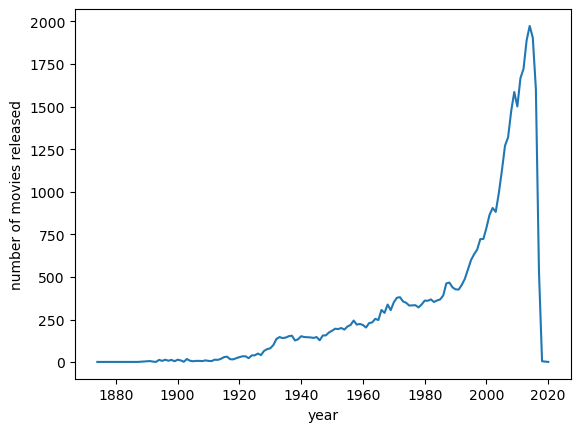

In [53]:
year_df = meta_df
year_df['release_date'] = pd.to_datetime(meta_df['release_date']).dt.year
year_counts = year_df.groupby('release_date').size()
plt.plot(year_counts)
plt.xlabel('year')
plt.ylabel('number of movies released')
plt.show()

#### 4.2 Investigate trends in movie revenues over the years

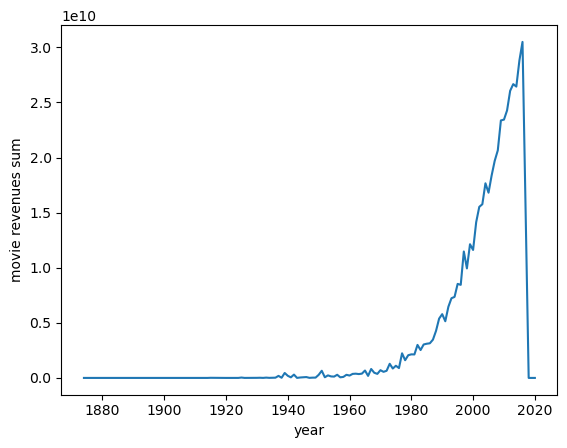

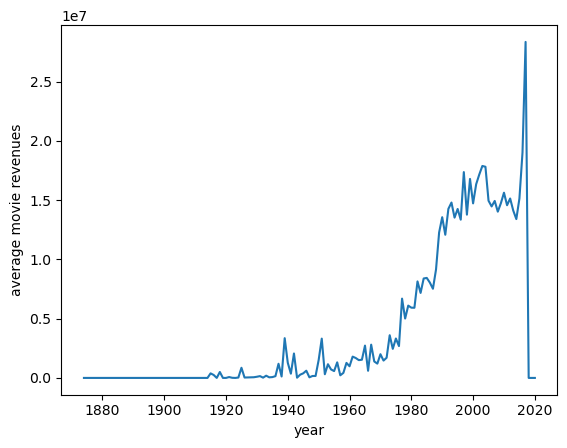

In [56]:
year_rev_df = year_df.groupby('release_date')['revenue']

plt.plot(year_rev_df.sum())
plt.xlabel('year')
plt.ylabel('movie revenues sum')
plt.show()

plt.plot(year_rev_df.mean())
plt.xlabel('year')
plt.ylabel('average movie revenues')
plt.show()

### 5. Basic Calculations :
- Calculate the average revenue of movies for each year.
- Determine the average movie rating for each genre.

#### 5.1 Calculate the average revenue of movies for each year.
这题是不是和上面重了？

In [60]:
pd.DataFrame(year_rev_df.mean())

,revenue
release_date,
1874.0,0.000000e+00
1878.0,0.000000e+00
1883.0,0.000000e+00
1887.0,0.000000e+00
1888.0,0.000000e+00
...,...
2015.0,1.512827e+07
2016.0,1.901364e+07
2017.0,2.833815e+07


#### 5.2 Determine the average movie rating for each genre.
这题是不是也和上面重了？

In [61]:
pd.DataFrame(avg_rating)

,rating
genre,
Action,3.558277
Adventure,3.503404
Animation,3.597373
Comedy,3.536900
Crime,3.572401
Documentary,3.485778
Drama,3.535949
Family,3.396431
Fantasy,3.507117


### 6. Insights and Conclusion:
- Summarize your key findings from the EDA and Genre Analysis.
- Discuss any interesting trends observed in the Temporal Trends section.